# Option IV Prediction Notebook

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [3]:
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')
sample_sub = pd.read_csv('sample_submission.csv')

## Data Exploration

In [4]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

print("\nTrain columns:")
print(train.columns.tolist())

print("\nTest columns:")
print(test.columns.tolist())

Train shape: (178340, 97)
Test shape: (12065, 96)
Sample submission shape: (12065, 53)

Train columns:
['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600', 'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800', 'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900', 'put_iv_25000', '

## IV Columns Analysis

In [8]:
# Get IV columns from sample submission (excluding timestamp)
sample_iv_cols = [col for col in sample_sub.columns if col != 'timestamp']

# Get IV columns that exist in both train and test data
iv_columns = [col for col in sample_iv_cols 
              if col in train.columns and col in test.columns]

print(f"Number of IV columns in sample submission: {len(sample_iv_cols)}")
print(f"Number of IV columns in both train and test: {len(iv_columns)}")
print("\nFirst 10 IV columns:")
print(iv_columns[:10])

Number of IV columns in sample submission: 52
Number of IV columns in both train and test: 42

First 10 IV columns:
['call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900']


## Strike Price Analysis

In [9]:
# Create strike dictionary from TEST columns
strike_dict = {}
for col in iv_columns:
    strike = col.split('_')[-1]
    if strike not in strike_dict:
        strike_dict[strike] = {'call': None, 'put': None}
    
    if col.startswith('call_iv_'):
        strike_dict[strike]['call'] = col
    else:
        strike_dict[strike]['put'] = col

print(f"Number of unique strikes: {len(strike_dict)}")
print("Sample strike dictionary entries:")
print(dict(list(strike_dict.items())[:3]))

Number of unique strikes: 31
Sample strike dictionary entries:
{'24000': {'call': 'call_iv_24000', 'put': 'put_iv_24000'}, '24100': {'call': 'call_iv_24100', 'put': 'put_iv_24100'}, '24200': {'call': 'call_iv_24200', 'put': 'put_iv_24200'}}


## Missing Values Analysis

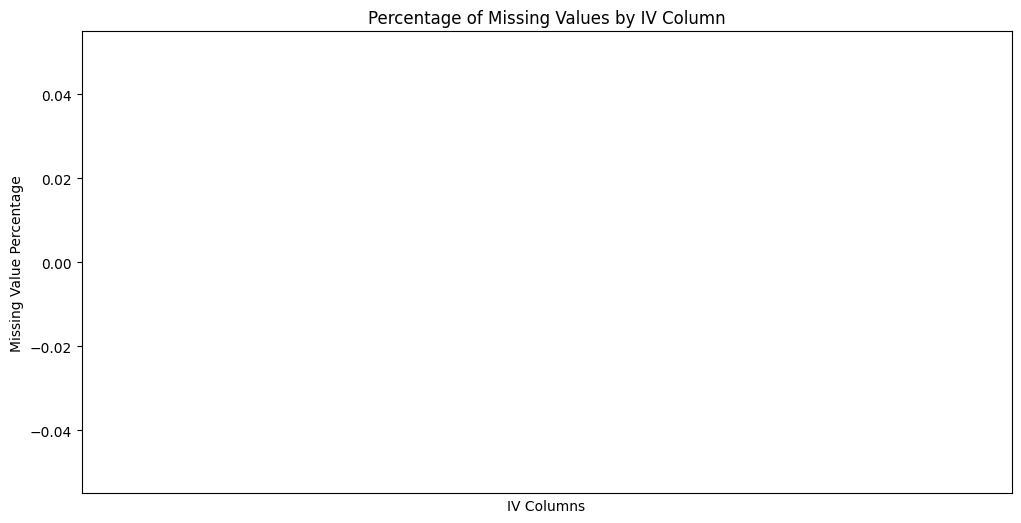

In [10]:
# Plot missing values in training data
missing_values = train[iv_columns].isna().mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar')
plt.title('Percentage of Missing Values by IV Column')
plt.ylabel('Missing Value Percentage')
plt.xlabel('IV Columns')
plt.xticks([])
plt.show()

## Global Means Calculation

In [11]:
# Pre-calculate global means from training data
global_means = {}
for col in iv_columns:
    if col in train.columns:
        global_means[col] = train[col].mean()
overall_mean = np.mean(list(global_means.values())) if global_means else 0.2

print(f"Overall mean IV: {overall_mean:.4f}")
print("Sample column means:")
print(dict(list(global_means.items())[:5]))

Overall mean IV: -12.4045
Sample column means:
{'call_iv_24000': np.float64(1.5803173304391611), 'call_iv_24100': np.float64(0.1952128715991925), 'call_iv_24200': np.float64(0.16099717636929461), 'call_iv_24300': np.float64(0.14009934083043626), 'call_iv_24400': np.float64(0.14688345825782215)}


## Prediction Function

In [12]:
def predict_iv(data):
    data = data.copy()
    
    # Phase 1: Strict put-call parity
    for strike, cols in strike_dict.items():
        call_col = cols['call']
        put_col = cols['put']
        
        if call_col in data.columns and put_col in data.columns:
            # Fill calls using puts where possible
            call_mask = data[call_col].isna() & data[put_col].notna()
            data.loc[call_mask, call_col] = data.loc[call_mask, put_col]
            
            # Fill puts using calls where possible
            put_mask = data[put_col].isna() & data[call_col].notna()
            data.loc[put_mask, put_col] = data.loc[put_mask, call_col]
    
    # Phase 2: Row-wise mean imputation
    for idx, row in data.iterrows():
        # Collect all available IV values in this row
        available_ivs = []
        for col in iv_columns:
            if col in row and not pd.isna(row[col]):
                available_ivs.append(row[col])
        
        if available_ivs:
            row_mean = np.mean(available_ivs)
        else:
            row_mean = overall_mean
            
        # Apply row mean to all missing IVs in this row
        for col in iv_columns:
            if col in data.columns and pd.isna(data.at[idx, col]):
                data.at[idx, col] = row_mean
    
    return data

## Validation Split

In [13]:
# Create validation split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

print(f"Training split shape: {train_df.shape}")
print(f"Validation split shape: {val_df.shape}")

Training split shape: (142672, 97)
Validation split shape: (35668, 97)


## Validation Prediction

In [14]:
# Apply to validation set
val_pred = predict_iv(val_df)

# Calculate MSE only on originally masked validation points
mse_vals = []
for col in iv_columns:
    if col in val_df.columns and col in val_pred.columns:
        # Focus only on points that were originally missing
        mask = val_df[col].isna() & val_pred[col].notna()
        if mask.any():
            se = (val_df.loc[mask, col] - val_pred.loc[mask, col]) ** 2
            mse_vals.append(se.mean())

validation_mse = np.mean(mse_vals) if mse_vals else 0
print(f"Validation MSE (masked points only): {validation_mse:.12f}")

Validation MSE (masked points only): 0.000000000000


## Test Prediction

In [15]:
# Apply to test set
test_pred = predict_iv(test)

# Check for missing values
missing_in_test = test_pred[iv_columns].isna().sum().sum()
print(f"Missing values in test predictions: {missing_in_test}")

Missing values in test predictions: 0


## Prepare Submission

In [17]:
# Prepare submission
submission = test_pred[['timestamp'] + iv_columns].copy()

# Verify no missing values
assert submission.isna().sum().sum() == 0, "Missing values detected"
submission.to_csv('submission.csv', index=False)

print("\nFinal Submission Preview:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Validation MSE: {validation_mse:.12f}")


Final Submission Preview:
   timestamp  call_iv_24000  call_iv_24100  call_iv_24200  call_iv_24300  \
0          0       0.280939       0.253561       0.253561       0.253561   
1          1       0.270276       0.292600       0.258893       0.292600   
2          2       0.223272       0.251731       0.223272       0.223272   
3          3       0.241888       0.224810       0.220505       0.210733   
4          4       0.235328       0.208829       0.222983       0.214126   

   call_iv_24400  call_iv_24500  call_iv_24600  call_iv_24700  call_iv_24800  \
0       0.242149       0.253561       0.232439       0.253561       0.222997   
1       0.244875       0.292600       0.233548       0.228209       0.292600   
2       0.214869       0.204580       0.194604       0.188052       0.223272   
3       0.198602       0.186190       0.224810       0.166394       0.161561   
4       0.208829       0.199485       0.192603       0.208829       0.208829   

   ...  put_iv_24100  put_iv_24200 

## Distribution of Predicted IVs

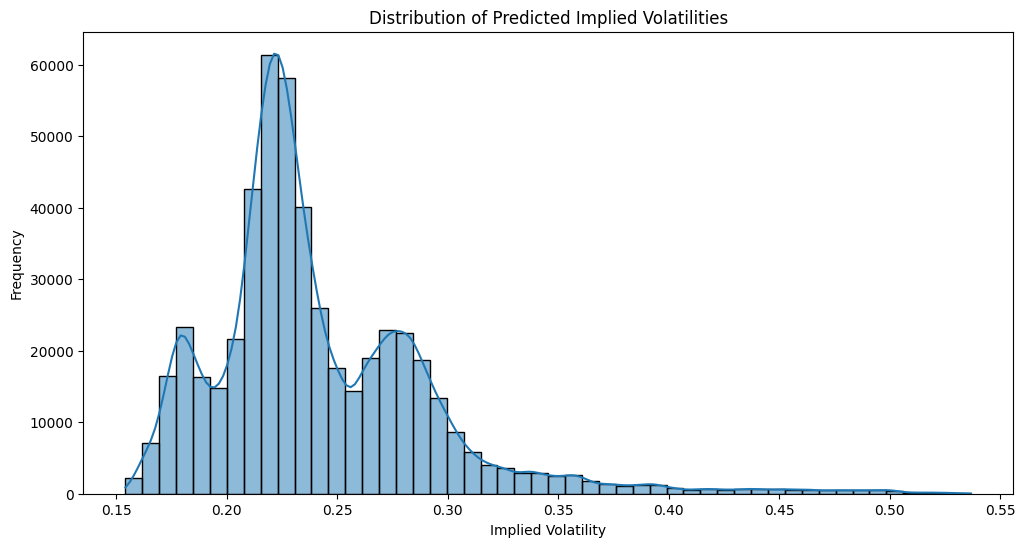

In [18]:
# Plot distribution of predicted IV values
plt.figure(figsize=(12, 6))
sns.histplot(submission.iloc[:, 1:].values.flatten(), bins=50, kde=True)
plt.title('Distribution of Predicted Implied Volatilities')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')
plt.show()